<a href="https://colab.research.google.com/github/cayo1cezar/Shakespeare/blob/main/Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf, numpy as np 
from tensorflow import keras 
from keras import layers 
from keras.preprocessing.text import Tokenizer 
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
#
import matplotlib.pyplot as plt
import re, string # expressões regulares
plt.style.use('ggplot')


In [3]:
text = open('shakespeare.txt').read()
text = text.lower()# somente letras minusculas
text = text.replace('\n', ' \n ') # considerar \n como palavra
text_words = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
text_words = [re.sub(r'[^\x00-\x7f]',r'', s) for s in text_words]# remove numeros e acentos
print('Quantidade Total de Palavras: ', len(text_words))
print(text_words[:10])

Quantidade Total de Palavras:  242651
['first', 'citizen:', '\n', 'before', 'we', 'proceed', 'any', 'further,', 'hear', 'me']


In [4]:
vocab_size = 500 # tamanho do vocabulário
# criando tokenizer (usa somente as 'VOCAB_SIZE' palavras mais comuns)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>',
                      filters='[^\x00-\x7f]')
# definindo vocabulario
tokenizer.fit_on_texts(text_words)
# tokenizando as palavras
tokens = tokenizer.texts_to_sequences(text_words)
tokens = [int(t[0]) for t in tokens] # lista para inteiros
print(text_words[:8])
print(tokens[:8])

['first', 'citizen:', '\n', 'before', 'we', 'proceed', 'any', 'further,']
[84, 229, 2, 148, 33, 1, 131, 1]


In [5]:
step = 1 # distancia a cada fatia 
sentences = [] # frases X
next_words = [] # palavras Y
seq_len = 10 # número de tokens por frase
for i in range(0, len(tokens) - seq_len, step):
    # Only add sequences where no word is in ignored_words
    sentences.append(tokens[i: i + seq_len])
    next_words.append(tokens[i + seq_len])
   
print(f'[+] Instâncias para treino: {len(sentences)}')
for i in range(5):
    print(sentences[i],'-->',next_words[i])

[+] Instâncias para treino: 242641
[84, 229, 2, 148, 33, 1, 131, 1, 126, 27] --> 1
[229, 2, 148, 33, 1, 131, 1, 126, 27, 1] --> 2
[2, 148, 33, 1, 131, 1, 126, 27, 1, 2] --> 2
[148, 33, 1, 131, 1, 126, 27, 1, 2, 2] --> 1
[33, 1, 131, 1, 126, 27, 1, 2, 2, 1] --> 2


In [6]:
# mostra shape atual
train_x = np.array(sentences) # pega as sentenças
train_y = np.array(next_words) # pega as palavras seguintes
print('Shape X:',train_x.shape)
print('Shape Y:',train_y.shape)
# codificando para one-hot
train_x_onehot = to_categorical(train_x, num_classes=vocab_size)
train_y_onehot = to_categorical(train_y, num_classes=vocab_size)
# train_x:(num_exemplos, num_tokens, vocab_size)
print('Shape X após one-hot:',train_x_onehot.shape)
# train_y:(num_exemplos,vocab_size)
print('Shape Y após one-hot:',train_y_onehot.shape)

Shape X: (242641, 10)
Shape Y: (242641,)
Shape X após one-hot: (242641, 10, 500)
Shape Y após one-hot: (242641, 500)


In [7]:
model = keras.Sequential([
    layers.LSTM(64, input_shape=(seq_len, vocab_size), return_sequences=False,),
    layers.Dense(vocab_size, activation='softmax')
])

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                144640    
                                                                 
 dense (Dense)               (None, 500)               32500     
                                                                 
Total params: 177,140
Trainable params: 177,140
Non-trainable params: 0
_________________________________________________________________


In [9]:
train_history = model.fit(train_x_onehot, train_y_onehot, validation_split=0.2,
                    epochs=15, batch_size=256)

Epoch 1/15
759/759 [==============================] - 54s 68ms/step - loss: 3.9120 - accuracy: 0.2847 - val_loss: 3.7802 - val_accuracy: 0.3187
Epoch 2/15
759/759 [==============================] - 50s 67ms/step - loss: 3.6677 - accuracy: 0.3452 - val_loss: 3.7029 - val_accuracy: 0.3438
Epoch 3/15
759/759 [==============================] - 53s 70ms/step - loss: 3.5130 - accuracy: 0.3764 - val_loss: 3.5638 - val_accuracy: 0.3748
Epoch 4/15
759/759 [==============================] - 51s 67ms/step - loss: 3.3612 - accuracy: 0.3941 - val_loss: 3.4823 - val_accuracy: 0.3861
Epoch 5/15
759/759 [==============================] - 53s 70ms/step - loss: 3.2606 - accuracy: 0.4011 - val_loss: 3.4180 - val_accuracy: 0.4000
Epoch 6/15
759/759 [==============================] - 51s 67ms/step - loss: 3.1893 - accuracy: 0.4059 - val_loss: 3.3690 - val_accuracy: 0.4027
Epoch 7/15
759/759 [==============================] - 53s 70ms/step - loss: 3.1377 - accuracy: 0.4088 - val_loss: 3.3417 - val_accuracy:

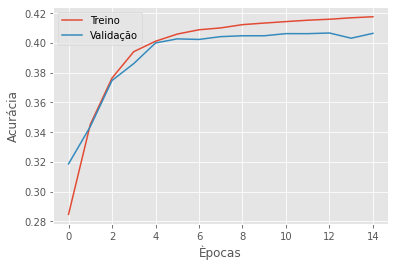

In [10]:
plt.plot(train_history.history['accuracy'], label='Treino')
plt.plot(train_history.history['val_accuracy'], label='Validação')
plt.xlabel('Èpocas');plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [11]:
seed_text = ['ROMEO:'] # frase inicial
seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
# preenche sequencia com zeros para ter o comprimento adequado pra rede
tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
pred_y = model.predict(tokens_x)[0] # preve probabilidades para a proxima palavra
print(f'Quantidade de Probabilidades: {len(pred_y)}')
print(pred_y[:4])

1/1 [==============================] - 2s 2s/step
Quantidade de Probabilidades: 500
[2.9367515e-12 8.5701299e-04 9.9759346e-01 3.6386562e-05]


In [12]:
# pega indice da palavra com maior probabilidade 
next_token = np.argmax(pred_y,)
# realiza a inversão de token para palavra
next_word = tokenizer.sequences_to_texts([[next_token]])
print('Proximo token: ', next_token, '-->', next_word)

Proximo token:  2 --> ['\n']


In [13]:
def sample_word(pred_y, temperature=1.0):
    pred_y = pred_y / temperature # 'força' das probabilidades
    pred_token = tf.random.categorical(pred_y, 1).numpy()
    return pred_token # token de saída

In [14]:
seed_text = ['ROMEO:'] # frase inicial
seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
print(seed_text, ' tokenizado fica: ', seed_tokens)
# preenche sequencia com zeros para ter o comprimento adequado pra rede
tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
pred_y = model.predict(tokens_x) # preve probabilidades para a proxima palavra
next_token = sample_word(pred_y)
# realiza a inversão de token para palavra
next_word = tokenizer.sequences_to_texts(next_token)
print('Proximo token: ', next_token, '-->', next_word)

['ROMEO:']  tokenizado fica:  [146]
1/1 [==============================] - 0s 66ms/step
Proximo token:  [[282]] --> ['away']


In [15]:
seed_text = ['ROMEO:'] # frase inicial
next_words = 100 # 100 próximas palavras
# substitui palavras por tokens
seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
print(seed_text, ' tokenizado fica: ', seed_tokens)
for _ in range(next_words):
    # preenche sequencia com zeros para ter o comprimento adequado pra rede
    tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
    # transforma tokens em vetor one-hot
    tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
    # preve probabilidades para a proxima palavra
    pred_y = model.predict(tokens_x)
    # faz amostragem com base nas probabilidades
    next_token = sample_word(pred_y, 0.2)
    next_token = next_token.flatten()[0] # pega valor como um int
    # anexa token a lista
    seed_tokens.append(next_token) 
    
# como a saída é um conjunto de tokens
# realiza a inversão para palavras, usando word_index
resultado = tokenizer.sequences_to_texts([seed_tokens])
print('\n')
print(resultado[0])

['ROMEO:']  tokenizado fica:  [146]
1/1 [==============================] - 0s 18ms/step


romeo: yet iii: death. us, beseech left juliet: live mean dear blood pray edward sir holy mine wife, 
 long warwick: again. marcius: 'tis shall hastings: him king thou, dost 
 mother prince three volumnia: it. o'er true in an down ay, stand death, hear romeo: 
 son, love, is, gremio: rest call anne: god royal high well. either wife what better our why i, 
 myself daughter i little tell her lords, you: i' holy but been no didst edward's show nor an son either thus 
 duke young hope edward brother, his o god polixenes: here's away he's but
